In [2]:
# import all modules here
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision import models

In [3]:
def load_data(number: int, data_type: str, part: str):
    """
    Loads image and label data based on the provided number, type, and part.
    Parameters:
        number (int): A number from 1 to 10, specifying the dataset part.
        data_type (str): A string, either 'eval' or 'train', specifying the dataset type.
        part (str): A string, either 'one' or 'two', specifying the dataset part.
    Returns:
        tuple: A tuple containing two arrays, images and labels if available, otherwise only images.
    Raises:
        ValueError: If `number` is not between 1 and 10, `data_type` is not 'eval' or 'train',
                    or `part` is not 'one' or 'two'.
    """

    # Check if inputs are valid
    if number not in range(1, 11):
        raise ValueError("Number must be between 1 and 10.")
    if data_type not in ["eval", "train"]:
        raise ValueError("Type must be 'eval' or 'train'.")
    if part not in ["one", "two"]:
        raise ValueError("Part must be 'one' or 'two'.")

    # Construct the path
    path = f'dataset/part_{part}_dataset/{data_type}_data/{number}_{data_type}_data.tar.pth'
    
    # Load data
    data = torch.load(path)
    images = data.get('data')  # Expected shape (2500, 32, 32, 3)
    
    if 'targets' in data:
        labels = data['targets']  # Expected shape (2500,)
        return images, labels
    else:
        return images  # Return only images if labels are not present

In [4]:
images, labels = load_data(1, "train", "one")

/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3845036888.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


In [5]:
#Number of unique labels
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
def visualize_images(images, labels, num_images=30):
    """
    Visualizes the first `num_images` images and their corresponding labels in a grid.
    Parameters:
        images : ndarray, labels : ndarray.
        num_images (int): Number of images to display (default is 30).
    """
    # Set up the grid for displaying images
    num_images = min(num_images, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols 
    
    plt.figure(figsize=(10, rows * 2))  # Adjust figure size based on number of rows
    
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap= 'gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

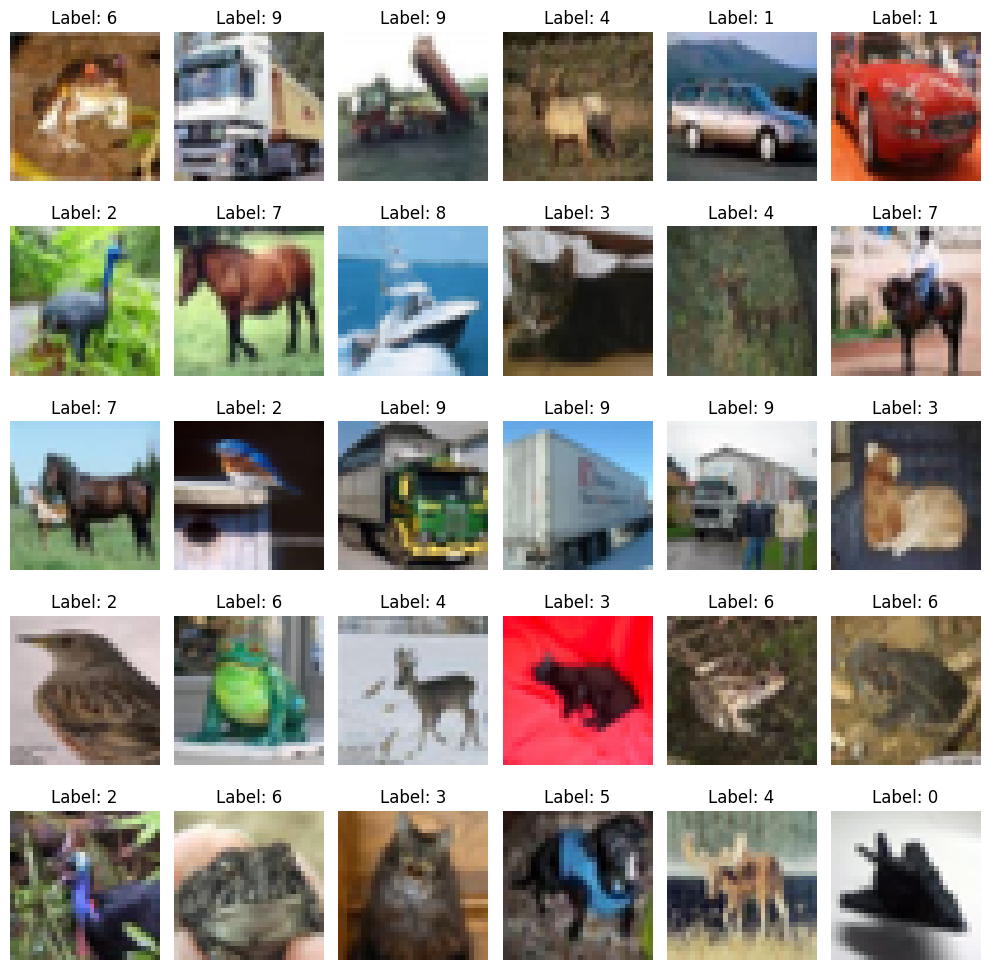

In [7]:
visualize_images(images, labels)

In [8]:
# def convert_to_grayscale(images):
#     """
#     Converts a batch of RGB images to grayscale.
#     Parameters: images -> (N, 32, 32, 3) Returns: ndarray -> (N, 32, 32)
#     """
#     N = len(images)
#     grayscale_images = np.zeros((N, 32, 32), dtype = np.uint8)

#     for k in range(N):
#         for i in range(len(images[k])):
#             for j in range(len(images[k][0])):
#                 grayscale_images[k][i][j] = 0.3 * images[k][i][j][0] + 0.59 * images[k][i][j][1] + 0.11 * images[k][i][j][2]
    
#     return grayscale_images

# Above code very slow ->

def convert_to_grayscale(images):
    N = images.shape[0] 
    grayscale_images = np.zeros((N, 32, 32), dtype=np.uint8) 

    grayscale_images = (0.2989 * images[:, :, :, 0] + 
                        0.5870 * images[:, :, :, 1] + 
                        0.1140 * images[:, :, :, 2]).astype(np.uint8)

    return grayscale_images

In [9]:
images = convert_to_grayscale(images)
images.shape

(2500, 32, 32)

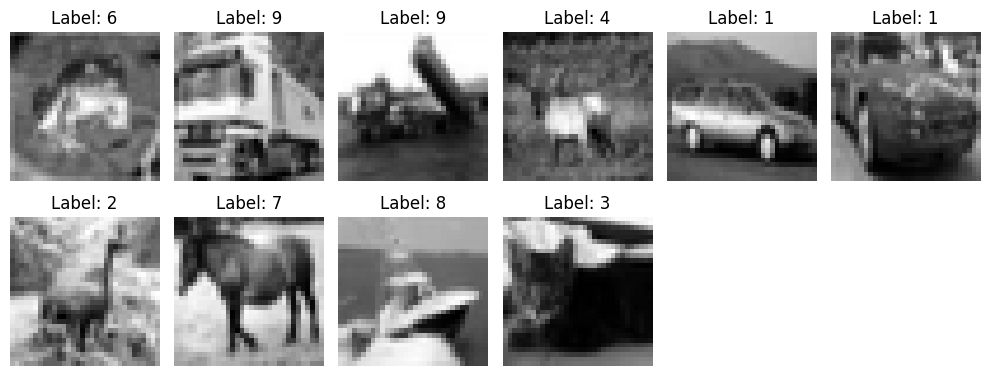

In [10]:
visualize_images(images, labels, 10)

In [11]:
 # Flatten each 32x32 image to a 1024-dimensional vector
N = images.shape[0]
flattened_images = images.reshape(N, -1) 

In [12]:
flattened_images.shape

(2500, 1024)

In [13]:
class LwP:
    def __init__(self, n_prototypes):
        """
        Parameters:
            n_prototypes (int): Number of distinct labels.
        """
        self.n_prototypes = n_prototypes
        self.prototypes = None
        self.labels = None
        self.inv_cov_matrix = None
        self.class_counts = None  # Track the count of samples per class
        self.label_to_index = {}  # Maps each label to an index in the prototypes array

    def fit(self, X, y):
        """
        Trains the model by finding prototypes based on the training data.
        Parameters:
            X (ndarray) -> (N, 1024)
            y (ndarray): Labels -> (N,)
        """
        unique_labels = np.unique(y)
        self.labels = unique_labels
        self.prototypes = np.zeros((self.n_prototypes, X.shape[1]))  # Placeholder for prototypes
        self.class_counts = np.zeros(self.n_prototypes, dtype=int)

        # Create label-to-index mapping
        self.label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

        # Calculate prototypes for each label
        for label in unique_labels:
            class_samples = X[y == label]
            if len(class_samples) > 0:
                idx = self.label_to_index[label]
                self.prototypes[idx] = np.mean(class_samples, axis=0)
                self.class_counts[idx] = len(class_samples)

        # Compute the covariance matrix of the dataset and its inverse
        covariance_matrix = np.cov(X, rowvar=False)
        self.inv_cov_matrix = np.linalg.inv(covariance_matrix)

    def mahalanobis_distance(self, a, b):
        """
        Parameters:
            a (ndarray): First vector.
            b (ndarray): Second vector.
        Returns:
            float: Mahalanobis distance between a and b.
        """
        diff = a - b
        return np.sqrt(np.dot(np.dot(diff, self.inv_cov_matrix), diff.T))

    def update(self, X_new, y_new):
        """
        Updates the model with new training examples.
        Parameters:
            X_new (ndarray): New samples -> (M, 1024)
            y_new (ndarray): New labels -> (M,)
        """
        for label in np.unique(y_new):
            new_samples = X_new[y_new == label]
            n_new = len(new_samples)
            if n_new > 0:
                idx = self.label_to_index.get(label)
                if idx is None:
                    raise ValueError(f"Label {label} not found in the model. Ensure that all labels are initialized in fit.")

                current_count = self.class_counts[idx]
                total_count = current_count + n_new
                new_mean = np.mean(new_samples, axis=0)
                
                # Update prototype as a weighted mean
                self.prototypes[idx] = (current_count * self.prototypes[idx] + n_new * new_mean) / total_count
                self.class_counts[idx] = total_count

        # Update covariance matrix based on the combined data
        combined_X = np.vstack([self.prototypes, X_new])
        covariance_matrix = np.cov(combined_X, rowvar=False)
        self.inv_cov_matrix = np.linalg.inv(covariance_matrix)

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            distances = np.zeros(len(self.labels))
            for j, prototype in enumerate(self.prototypes):
                distances[j] = self.mahalanobis_distance(X[i], prototype)
            predictions[i] = self.labels[np.argmin(distances)]

        return predictions


In [14]:

model = LwP(n_prototypes=10)
model.fit(flattened_images, labels)


In [15]:
# loading eval dataset
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = convert_to_grayscale(X_eval)
X_eval = X_eval.reshape(X_eval.shape[0], -1)
y_eval


/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3845036888.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


array([5, 3, 7, ..., 5, 4, 6])

In [16]:
predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 15.64%


## Trying new Approach by extracting features using Neural Network

In [33]:
def extract_features(images):
    """
    Extract features from a batch of CIFAR-10 images using a pre-trained ResNet18 model.

    Args:
        images (numpy.ndarray): A 4D array of shape (N, 32, 32, 3), where N is the number of images.

    Returns:
        torch.Tensor: A 2D tensor of shape (N, 512) containing the extracted features.
    """
    
    # Step 1: Convert the input images to a tensor and apply transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert to PIL Image
        transforms.Resize(224),   # Resize to 224x224
        transforms.ToTensor(),     # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ])

    # Transform each image and create a tensor
    transformed_images = torch.stack([transform(images[i]) for i in range(images.shape[0])])

    # Step 2: Load pre-trained ResNet18 model
    model = models.resnet18(pretrained=True)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the classification layer
    model.eval()  # Set the model to evaluation mode

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    transformed_images = transformed_images.to(device)

    # Step 3: Feature extraction
    with torch.no_grad():
        features = model(transformed_images)  # Get features
        features = features.view(features.size(0), -1)  # Flatten the output
    
    return np.array(features)

In [18]:
X_train, y_train = load_data(1, "train", "one")
X_train = extract_features(X_train)     
print(X_train.shape)

/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3845036888.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)
/Users/mufeedamir/mi

cpu
torch.Size([2500, 512])


In [19]:
X_train=np.array(X_train)

In [29]:
model = LwP(n_prototypes=10)
model.fit(X_train, y_train)

In [21]:
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = extract_features(X_eval)
predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')

/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3845036888.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


cpu


/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3694223853.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  return np.sqrt(np.dot(np.dot(diff, self.inv_cov_matrix), diff.T))


Accuracy: 81.68%


In [ ]:
X_train2 = extract_features(load_data(2, "train", "one"))   


/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3845036888.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


cpu


In [30]:
X_train2 = np.array(X_train2)
y_label2 = model.predict(X_train2)

In [31]:
model.update(X_train2, y_label2)

In [32]:
predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 79.40%


In [35]:
X_eval2, y_eval2 = load_data(2, "eval", "one")

/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_30603/3845036888.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


In [37]:
X_eval2 = extract_features(X_eval2)

/Users/mufeedamir/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mufeedamir/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [38]:
predictions = model.predict(X_eval2)
accuracy = np.mean(predictions == np.asarray(y_eval2))
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 79.48%
